# MSc in AI - CE6002 & CS5062


# E-tivity 4: Overfitting & How to Prevent It
# CE6002 - Performance of Classifiers - Tasks 1, 2 and 3

## Student Name: Mark Murnane
## Student ID: 18195326
-----

All necessary imports are provided. Please do not add further imports.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

Below is the exact same data you used for the regression in E-tivity 3, but this time you know exactly what function generated the data

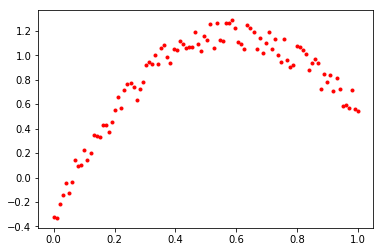

In [2]:
def target(X):
    #return: 0.5X^5-0.5X^3-4.25X^2+5.125X-0.4375
    return 0.5*((X-.5)-10*(X-.5)**2-(X-.5)**3+X**5)+1

points = 100
X = np.linspace(0, 1, points) # 100 values between 0 and 100
noise=np.random.random(points)/4
y_nf = target(X) #noise free target
y = y_nf+noise #noisy target

plt.plot(X,y,'r.')
plt.show()

Below is an implementation of linear regression with regularization

In [3]:
def weights_reg(X,y,l):
    n = len(X)
    m=X.T.dot(X)
    return np.linalg.inv(m+l*np.identity(m.shape[0])).dot(X.T).dot(y)

In [4]:
def lin_reg(w,X):
    # Calculation of outputs given weights and data (X). Note that X needs to contain the bias of 1. 
    out=[]
    for x in X:
        out.append(w.T.dot(x))
    return np.array(out)

In [5]:
def calc_error(w,X,y):
    # Calculate the error as the mean squared error
    pred = lin_reg(w,X)
    return math.sqrt((pred-np.array(y)).dot(pred-np.array(y))/len(X))

To create higher order features:

In [6]:
def transPoly(X, power):
    # Extend the data in X with a bias (1) and powers of the feature up to 'power'
    ones = np.ones((X.shape[0],1))
    extra=[]
    for x in X:
        row=[]
        for p in range(2,power+1):
            row.append(x**p)
        extra.append(row)
    return np.concatenate((ones, X.reshape(len(X),1),np.array(extra)),1)

## Task 4


Iterate over lambda, train the model and calculate Eout. Plot the latter versus lambda to see how much regularization is required.

------

### Task 4.1

### Determine optimal value of $\lambda$

Based on the graphs in the _Regularisation_ lecture (slide 12) the initial range for $\lambda$ is from 0.0 to 0.01.  The intention is to cover a range from overfitting (too small a $\lambda$) to underfitting (too large a $\lambda$).  By including $\lambda = 0$ in the range, the _unregularised_ function is also included.

In [7]:
ein=[]
eout=[]
weights=[]

# Calculate over a range from 0 to 1.  Expected to cover a range from underfitting to overfitting
lambdas = np.linspace(0, 1, num=250)
        
X_trans = transPoly(X,50)
# random_state fixed to get reproducible (and 'good'! :-)) results
X_train, X_test, y_train, y_test = train_test_split(X_trans, y, train_size=0.9, random_state =5)
for l in lambdas:    
    w = weights_reg(X_train,y_train,l)
    ein.append(calc_error(w,X_train,y_train))
    eout.append(calc_error(w,X_test,y_test))
    weights.append(w)

D:\Masters\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


For now store the lowest values of $E_{in}$ and $E_{out}$ from the experiment and identify the lambda values that correspond to them.

In [8]:
# Get the minimum of both in- and out-of-sample errors
min_ein = np.amin(ein)
lambda_min_ein = lambdas[np.argmin(ein)]

min_eout = np.amin(eout)
lambda_min_eout = lambdas[np.argmin(eout)]

### Compare to  unregularised $E_{out}$

The value of $E_{out}$ without regularisation can be calculated by using $\lambda = 0$.

In the calculations above we lambdas[0] = 0, therefore the values of ein[0] and eout[0] represent the unregularised values of $E_{in}$ and $E_{out}$ respectively.

In [9]:
print(f"The unregularised value of Eout is {eout[0]:.6f}")
print(f"The best regularised value of Eout is {min_eout:.6f} and used lambda = {lambda_min_eout:.6f}")

The unregularised value of Eout is 0.610825
The best regularised value of Eout is 0.073878 and used lambda = 0.004016


### Plot of $E_{out}$ vs. $\lambda$

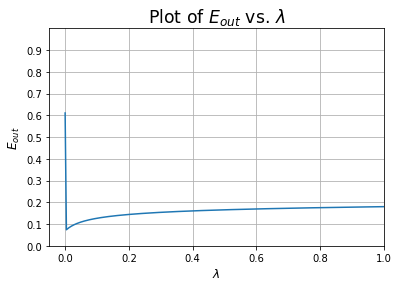

In [10]:
plt.plot(lambdas, eout)

plt.title("Plot of $E_{out}$ vs. $\lambda$", fontsize='xx-large')
plt.xlim(-0.05,1)
plt.xlabel("$\lambda$", fontsize='large')
plt.ylim(0,1)
plt.ylabel("$E_{out}$", fontsize='large')
plt.yticks(np.arange(0, 1, 0.1))
plt.grid()

plt.show()

### Plot overfit, underfit and optimal $\lambda$ models

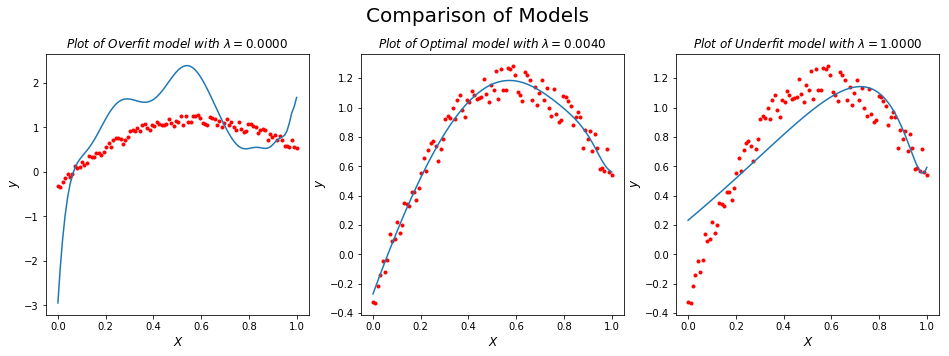

In [11]:
fig = plt.figure(figsize=(16,5))


fig.suptitle("Comparison of Models", fontsize=20)

plot_dict = {"Overfit": 0, "Optimal": lambda_min_eout, "Underfit": lambdas[-1]}

for i, (plot, l_val) in enumerate(plot_dict.items()):
    ax = fig.add_subplot(1, 3, i+1)
    
    # Plot the original function
    ax.plot(X,y,'r.')
    
    # Calculate and plot the the y values for the full spread of X (transposed to the higher order)
    model_y = lin_reg(weights[np.where(lambdas==l_val)[0][0]], X_trans)   
    ax.plot(X, model_y)  
    
    # Graph cleanup
    ax.set_title(f"Plot of {plot} model with $\lambda = {l_val:.4f}$", fontsize='large', fontstyle='italic')    
    ax.set_xlabel("X", fontsize='large', fontstyle='italic')
    ax.set_ylabel("y", fontsize='large', fontstyle='italic')

# Adjust title for good spacing
fig.subplots_adjust(top=0.85)

plt.show()